# Connectivity Constraint 

For manufacturability, it is often necessary to impose connectivity constraint during topological optimization, so that all solid pixels are connected to one side (e.g. the supporting substrate). Meep adjoint supports this feature and it is illustrated in this tutorial. Please also note that the connectivity constraint is independent from the rest of Meep, and may be used independently and separately.

The basic underlying idea is to solve for an auxilary artificial temperature field. For connected structure, heat can freely flow out through the supporing layer, so the temperature in the region should be low overall; on the other hand, for disconnected structure, heat will be trapped in islands, leading to high temperature in some area.

In [1]:
import meep as mp
from meep import Animate2D
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal

mp.verbosity(0)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1.0)

# I. Behavior of the Constraint

Given (filtered and projected) design variable `v` with size `(nz, ny, nx)`, `mpa.constraint_connectivity(v, nx, ny, nz)` computes and simultaneously outputs the constraint value (negative for connected structure, positive for disconnected structure) and the gradient of the constraint with respect to `v`. Additional chain rule needs to be applied for gradient with repect to the unprojected and unfiltered design variables.

The temperature field is also returned for debug and reference, but it can be ignored when using the constraint.
#### IMPORTANT: The solver will reshape input `v` via `np.reshape(v, (nz, ny, nx))`. For 2D structure, please specify `ny=1`. The solver assumes the last index of the 0-axis of the array (bottom side of the image from plt.imshow) is where the structure should be connected. So the user must first rotate the structure properly to match this condition; the gradient must also be post-processed and rotated so that the gradient corresponds correctly.

There are three important hyperparameter, `p`, `cond_s`, and `thresh`. It is advised to check and tune them for each individual problem setup so that the constraint behaves as expected. A tall design region might require larger `cond_s` and `thresh`, as the heat is more difficult to flow out. On the other hand, there are many good combinations, and a reasonably conservative `thresh` might be all one needs to tune. 

### disconnected structure

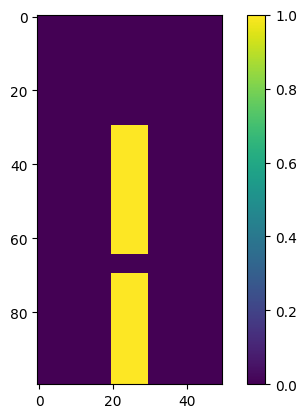

In [2]:
nz, ny, nx = 100, 1, 50
v = np.zeros((nz,ny,nx))
v[30:65,:,20:30]=1
v[70:,:,20:30]=1
plt.imshow(v[:,0,:])
plt.colorbar()

The structure above has one part that is connected to the bottom, while the other part is floating above and is disconnected. We can see overall has a positive constraint value of around 24

In [3]:
T, f, df_dv = mpa.constraint_connectivity(v, nx, ny, nz, p=3, cond_s=1e4, thresh=50)
f

24.234376324325485

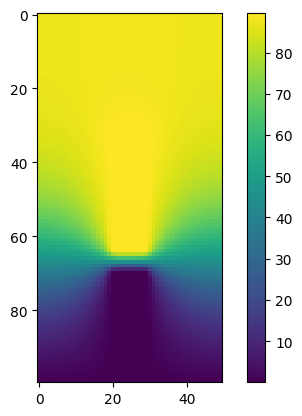

In [4]:
plt.imshow(T.reshape(nz, nx))
plt.colorbar()

The temperature in the region is plotted above. As we can see, only the top disconnected part is heated up, while the bottom connected part is cooled down. We also plotted the gradient below, which has large negative values between the two components, indicating strong tendency to connect the structure in order to lower the temperature.

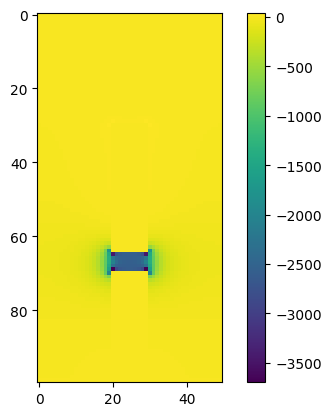

In [5]:
plt.imshow(df_dv.reshape(nz, nx))
plt.colorbar()

### connected structure

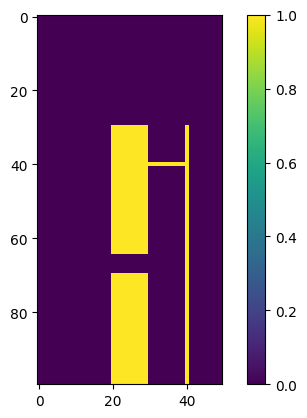

In [6]:

v[30:,:,40]=1
v[40,:,30:40]=1
plt.imshow(v[:,0,:])
plt.colorbar()

In [7]:
T, f, df_dv = mpa.constraint_connectivity(v, nx, ny, nz, p=3, cond_s=1e4, thresh=50)
f

-0.2505643580057533

If we connect the structure so that all solid pixel is path-connected to the bottom, we can see that the constraint value becomes negative, and the tempeature is low overall as heat is leaked through the bottom side. The gradient values are relatively small in generall as well, indicating no more change is needed to connect the structure.

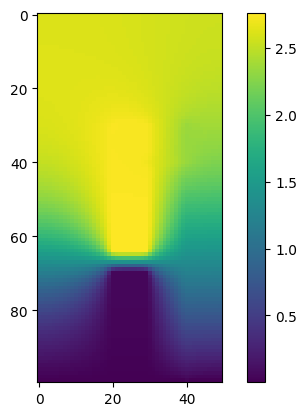

In [8]:
plt.imshow(T.reshape(nz, nx))
plt.colorbar()

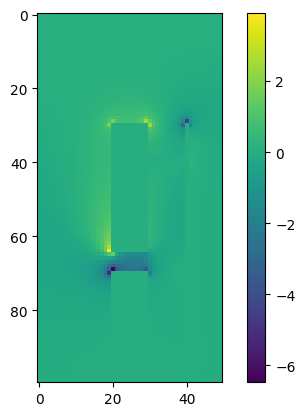

In [9]:
plt.imshow(df_dv.reshape(nz, nx))
plt.colorbar()

# II. Optimization Example

We further illustrates the constraint with the following topological optimization example. A simple metalens sitting on a substrate is designed to focus light. Length-scale and connectivity constraints are both imposed to ensure manufactuability. Length-scale is imposed so that components are connected by more than a narrow path of a few pixels, and eliminate small islands that don't signicantly violates the connectivity constraint.

In this example, we not only enforce solid pixels to connect to the substrate, we also enforce the void pixels to connect to the air above. Therefore, the structure has no holes and can be easily cleaned with alcohol.

In [10]:
pad = 0.1
design_region_width0 = 8
design_region_height0 = 2
design_region_width = design_region_width0 + 2*pad
design_region_height = design_region_height0 + 2*pad

pml_size = 1.0

resolution = 30

Sx = 2 * pml_size + design_region_width
Sy = 2 * pml_size + design_region_height + 3
cell_size = mp.Vector3(Sx, Sy)

nf = 1
frequencies = np.array([1 / 1.55])

minimum_length = 0.15  
eta_i = 0.5
eta_e = 0.65
eta_d = 1 - eta_e
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]



fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [0, -(design_region_height / 2 + 1), 0]
source_size = mp.Vector3(design_region_width, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

Nx = round(design_region_resolution * design_region_width)
Ny = round(design_region_resolution * design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si,damping=1.0*6.28*fcen)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


# Padding and masking the design region to ensure geometric constraints on the boundaries.
mask = pad
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")
left_mask = (X_g <= -(design_region_width/2-mask)) & (np.abs(Y_g) <= design_region_height / 2)
right_mask = (X_g >= design_region_width/2-mask) & (np.abs(Y_g) <= design_region_height / 2)
top_mask = (Y_g >= design_region_height/2-mask) & (np.abs(X_g) <= design_region_width / 2)
bottom_mask = (Y_g <= -(design_region_height/2-mask)) & (np.abs(X_g) <= design_region_width / 2)
Air_mask = left_mask | top_mask | right_mask

def mapping(x,eta,beta):                                                                                                                                                       
    xc = npa.where(bottom_mask.flatten(),1,npa.where(Air_mask.flatten(),0,x))
    xc = npa.reshape(xc, (Nx, Ny))                                                                                                                                        

    # filter                                                                                                                                                               
    filtered_field = mpa.conic_filter(xc,filter_radius,design_region_width,design_region_height, design_region_resolution)                                                                                                                                 
    return filtered_field.flatten()


# ``mapping_s`` and ``mapping_v`` are very important functions: they pre-process the design variables by masking, 
# filtering, projecting, and rotating to the proper orientation. The mapping function above is for the Maxwell solves, 
# and has no projection because that is taken care of as part of meep routine, using beta defined in the design variable. 
# On the other hand, for connectivity constraint, projection must be separatly specified. Afterwards, 
# ``rot90`` in ``mapping_s`` would rotate the meep design variables properly for the constraint, 
# so that connectivity of solid to the bottom is enforced. Similarly, in ``mapping_v``,
# ``1 - npa.rot90(projected_field,3)`` are for the void pixels to connect to the air above.
# Packing the preprocessing functions this way allows for easy post-processsing of the gradients with chain-rule.

def mapping_s(x,eta,beta):
    # filter
    xc = npa.where(bottom_mask.flatten(),1,npa.where(Air_mask.flatten(),0,x))
    xc = npa.reshape(xc, (Nx, Ny))
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width, design_region_height, design_region_resolution)
    # projection                                                                                                                                                          
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)

    rot_field = npa.rot90(projected_field)
    return rot_field.flatten()

def mapping_v(x,eta,beta):
    # filter      
    xc = npa.where(bottom_mask.flatten(),1,npa.where(Air_mask.flatten(),0,x))
    xc = npa.reshape(xc, (Nx, Ny))
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width, design_region_height, design_region_resolution)
    # projection                                                                                                                                                          
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)

    rot_field = 1 - npa.rot90(projected_field, 3)
    return rot_field.flatten()


geometry = [
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables),
    mp.Block(center=mp.Vector3(0, -design_region_height0 / 2 - 0.25), size=mp.Vector3(design_region_width, 0.5), material=Si),
]
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

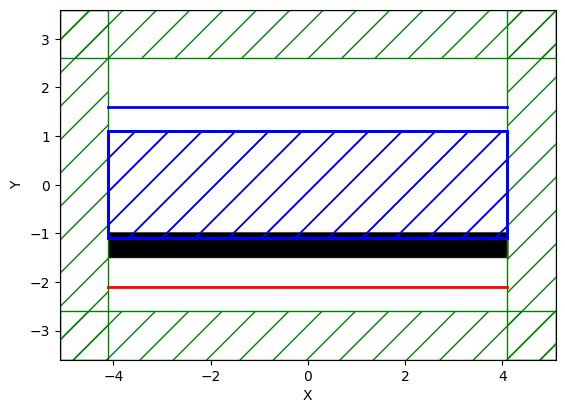

In [11]:
far_x = [mp.Vector3(0, 5, 0)]
NearRegions = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, design_region_height / 2 + 0.5),
        size=mp.Vector3(design_region_width, 0),
        weight=+1,
    )
]
FarFields = mpa.Near2FarFields(sim, NearRegions, far_x)
ob_list = [FarFields]

def J(FF):
    return npa.abs(FF[0, 0, 2]) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=500,
)
opt.plot2D(True)

Current iteration: 1
Starting forward run...


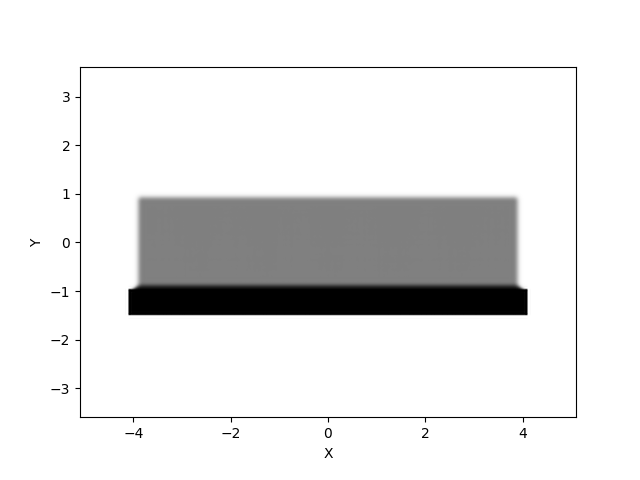

Starting adjoint run...
Calculating gradient...
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 8
Starting forward run...


/usr/local/lib/python3.9/site-packages/meep/geom.py:582: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


Starting adjoint run...
Calculating gradient...
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current itera

Calculating gradient...
Current iteration: 96
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 97
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 98
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 99
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 100
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 101
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 102
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 103
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 104
Starting forward run...
Starting adjoint run...
Calculating gradient...


In [12]:
evaluation_history = []
connectivity_s_history = []
connectivity_v_history = []
geom_s_history = []
geom_v_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))
    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

def connect_s(x,gradient,eta,beta):                                                                                                                                   

    v0 = x[:] # design parameters                                                                                                                                        
    v = mapping_s(v0,eta_i,beta)#pre-process with mapping_s
    _, f0, dJ_du = mpa.constraint_connectivity(v, Nx, 1, Ny, p=3, cond_s=500, thresh=30)
    dJ_du = np.squeeze(dJ_du)                                                                                                                        
    my_grad = tensor_jacobian_product(mapping_s,0)(v0,eta,beta,dJ_du)
    gradient[:] = my_grad.flatten()

    connectivity_s_history.append(f0)
    return f0

def connect_v(x,gradient,eta,beta):                                                                                                                                   

    v0 = x[:] # design parameters                                                                                                                                        
    v = mapping_v(v0,eta_i,beta)#pre-process with mapping_v
    _, f0, dJ_du = mpa.constraint_connectivity(v, Nx, 1, Ny, p=3, cond_s=500, thresh=30)
    dJ_du = np.squeeze(dJ_du)                                                                                                                        
    my_grad = tensor_jacobian_product(mapping_v,0)(v0,eta,beta,dJ_du)
    gradient[:] = my_grad.flatten()

    connectivity_v_history.append(f0)
    return f0

def geom_s(x,gradient,eta,beta):
                                                                                                                                            
    threshf = lambda v: mpa.tanh_projection(v,beta,eta)
    filterf = lambda v: mpa.conic_filter(v.reshape(Nx, Ny),filter_radius,design_region_width,design_region_height,design_region_resolution)
    v = x[:]

    v = npa.where(bottom_mask.flatten(),1,npa.where(Air_mask.flatten(),0,v))

    v_c=(filter_radius/resolution)**4                                                                                                                                  
    g_s = mpa.constraint_solid(v,v_c,eta_e,filterf,threshf,1)                                                                       
    g_s_grad = grad(mpa.constraint_solid,0)(v,v_c,eta_e,filterf,threshf,1)                                                                                                                                                                                                                 
    gradient[:]  = npa.where(bottom_mask.flatten() | Air_mask.flatten(),0,g_s_grad)
    geom_s_history.append(g_s)
    return float(g_s)-5e-4

def geom_v(x,gradient,eta,beta):
                                                                                                                                            
    threshf = lambda v: mpa.tanh_projection(v,beta,eta)
    filterf = lambda v: mpa.conic_filter(v.reshape(Nx, Ny),filter_radius,design_region_width,design_region_height,design_region_resolution)
    v = x[:]

    v = npa.where(bottom_mask.flatten(),1,npa.where(Air_mask.flatten(),0,v))
    v_c=(filter_radius/resolution)**4                                                                                                                                   
    g_v = mpa.constraint_void(v,v_c,eta_d,filterf,threshf,1)                                                                      
    g_v_grad = grad(mpa.constraint_void,0)(v,v_c,eta_d,filterf,threshf,1)                                                                                                                                                                                                                
    gradient[:]  = npa.where(bottom_mask.flatten() | Air_mask.flatten(),0,g_v_grad)
    geom_v_history.append(g_v)
    return float(g_v)-5e-4


%matplotlib ipympl
# Create the animation
animate = Animate2D(
    fields=None,
    realtime=True,
    eps_parameters={'contour': False, 'alpha': 1, 'frequency': 1/1.55},
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    update_epsilon=True,  # required for the geometry to update dynamically
    nb=True         # required if running in a Jupyter notebook
)
# This will trigger the animation at the end of each simulation
opt.step_funcs=[mp.at_end(animate)]


algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))


# Lenth-scale constraints are introduced in the last beta, as they requires almost binaried structures.
# Connectivity constraints are less well-defined when there are too many grey scale pixels, but they can 
# be introduced earlier to guide the evolution in the right direction before the structure gets too disconnected.

cur_beta = 8
beta_scale = 2
num_betas = 3
update_factor = 50
ftol = 1e-5
for iters in range(num_betas):
    design_variables.beta = cur_beta
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    if cur_beta >= 16:
        solver.add_inequality_constraint(lambda x,g: connect_s(x,g,eta_i, cur_beta), 1e-3)
        solver.add_inequality_constraint(lambda x,g: connect_v(x,g,eta_i, cur_beta), 1e-3)
    if cur_beta >= 32:
        solver.add_inequality_constraint(lambda x,g: geom_s(x,g,eta_i, cur_beta), 1e-3)
        solver.add_inequality_constraint(lambda x,g: geom_v(x,g,eta_i, cur_beta), 1e-3)
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

In [13]:
animate.to_jshtml(fps=5)

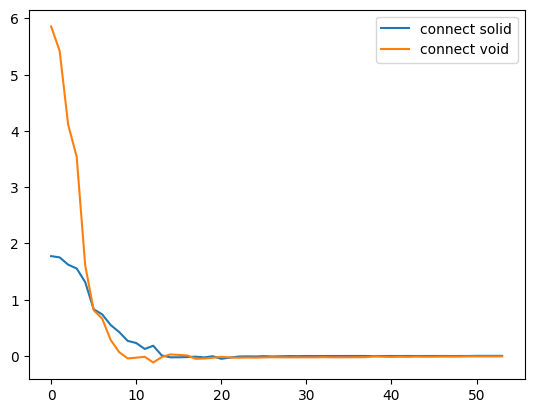

In [14]:
%matplotlib inline
plt.plot(connectivity_s_history, label="connect solid")
plt.plot(connectivity_v_history, label="connect void")
plt.legend()

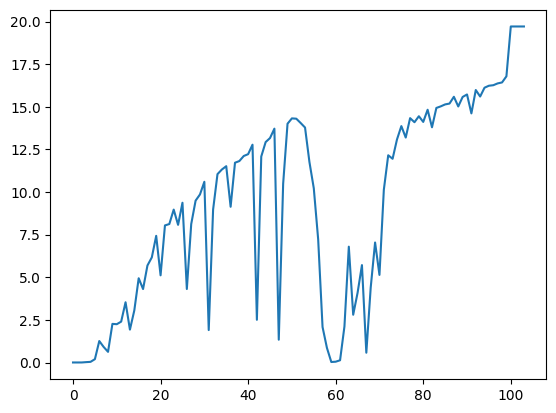

In [15]:
%matplotlib inline
plt.plot(evaluation_history)

FloatProgress(value=0.0, description='0% done ', max=500.0)

<AxesSubplot: xlabel='X', ylabel='Y'>

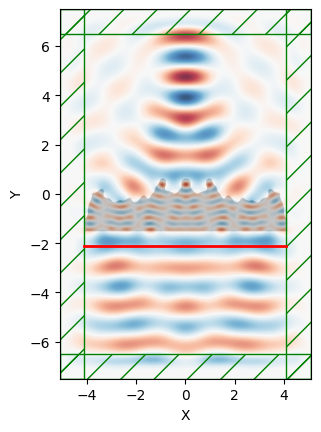

In [16]:
cwsrc = [mp.Source(mp.ContinuousSource(frequency=fcen), component=mp.Ez, size=source_size, center=source_center)]

sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, 15),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=cwsrc,
    default_material=Air,
    resolution=resolution,
)

sim.run(until=500)
%matplotlib inline
sim.plot2D(fields=mp.Ez)